In [46]:
import pandas as pd
import numpy as np
from lifetimes.utils import summary_data_from_transaction_data
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes.utils import calibration_and_holdout_data
from sklearn.metrics import mean_squared_error
import numpy as np
from lifetimes import BetaGeoFitter, GammaGammaFitter
import gc

In [2]:
event_df = pd.read_csv("../dataset/events_processed.csv")
# item_properties_part_1_df = pd.read_csv("../dataset/item_properties_part1_processed.csv")
# item_properties_part_2_df = pd.read_csv("../dataset/item_properties_part2_processed.csv")
item_properties_df = pd.read_csv("../dataset/item_properties_processed.csv")
event_df.head()
event_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
 5   ISO datetime   object 
 6   date           object 
dtypes: float64(1), int64(3), object(3)
memory usage: 147.2+ MB


In [3]:
# item_properties_df = pd.concat([item_properties_part_1_df, item_properties_part_2_df], ignore_index=True)
item_properties_df.head()

,timestamp,itemid,property,value,ISO datetime,date
0,1435460400000,460429,categoryid,1338,2015-06-28 03:00:00,2015-06-28
1,1441508400000,206783,888,1116713 960601 n277.200,2015-09-06 03:00:00,2015-09-06
2,1439089200000,395014,400,n552.000 639502 n720.000 424566,2015-08-09 03:00:00,2015-08-09
3,1431226800000,59481,790,n15360.000,2015-05-10 03:00:00,2015-05-10
4,1431831600000,156781,917,828513,2015-05-17 03:00:00,2015-05-17


## 1. RFM:  A behavioral segmentation technique used to quantify customer value by analyzing past purchase behavior

* R- Recency

In [4]:
transactions_df = event_df[event_df['event'] == 'transaction'].copy()
transactions_df["ISO datetime"] = pd.to_datetime(transactions_df["ISO datetime"])
print(transactions_df.info())
transactions_df.head()

# print(transactions_df["ISO datetime"].dtype)

<class 'pandas.core.frame.DataFrame'>
Index: 22457 entries, 130 to 2755607
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      22457 non-null  int64         
 1   visitorid      22457 non-null  int64         
 2   event          22457 non-null  object        
 3   itemid         22457 non-null  int64         
 4   transactionid  22457 non-null  float64       
 5   ISO datetime   22457 non-null  datetime64[ns]
 6   date           22457 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 1.4+ MB
None


,timestamp,visitorid,event,itemid,transactionid,ISO datetime,date
130,1433222276276,599528,transaction,356475,4000.0,2015-06-02 05:17:56.276,2015-06-02
304,1433193500981,121688,transaction,15335,11117.0,2015-06-01 21:18:20.981,2015-06-01
418,1433193915008,552148,transaction,81345,5444.0,2015-06-01 21:25:15.008,2015-06-01
814,1433176736375,102019,transaction,150318,13556.0,2015-06-01 16:38:56.375,2015-06-01
843,1433174518180,189384,transaction,310791,7244.0,2015-06-01 16:01:58.180,2015-06-01


In [5]:
# Xác định Ngày Tham Chiếu (NOW)
latest_purchase_date = transactions_df['ISO datetime'].max()
print(latest_purchase_date)
NOW = latest_purchase_date + pd.Timedelta(days=1) # Tăng thêm 1 ngày để đảm bảo tất cả các giao dịch đều trước Ngày Tham Chiếu

2015-09-18 02:43:12.017000


In [6]:
rfm_r_df = transactions_df.groupby('visitorid')['ISO datetime'].max().reset_index()    # ngày mua gần nhất
rfm_r_df.columns = ['visitorid', 'LastPurchaseDate']  
rfm_r_df['Recency'] = (NOW - rfm_r_df['LastPurchaseDate']).dt.days
rfm_r_df = rfm_r_df[['visitorid', 'Recency']]
rfm_r_df.head()

,visitorid,Recency
0,172,35
1,186,37
2,264,11
3,419,51
4,539,94


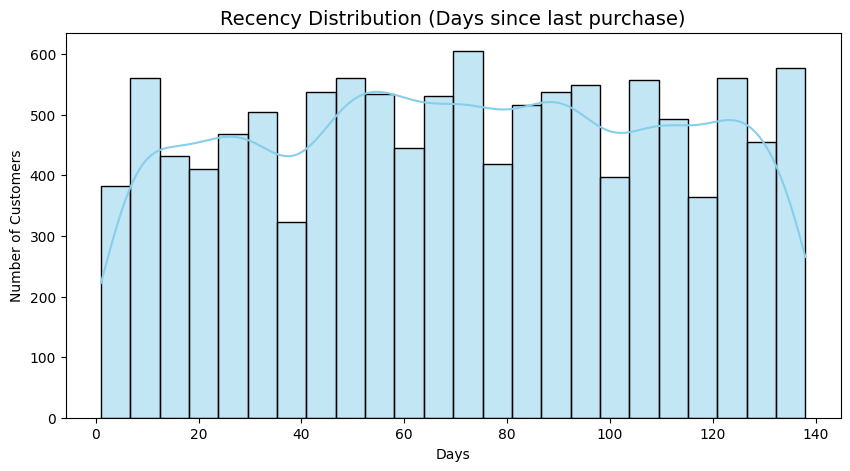

In [7]:
# visualization of Recency
plt.figure(figsize=(10, 5))
sns.histplot(rfm_r_df['Recency'], kde=True, color='skyblue')
plt.title('Recency Distribution (Days since last purchase)', fontsize=14)
plt.xlabel('Days')
plt.ylabel('Number of Customers')
plt.show()

* F - Frequency 

In [8]:
# Tính toán Frequency (F) 
# Đếm số lượng transactionid DUY NHẤT cho mỗi visitorid
rfm_f_df = transactions_df.groupby('visitorid')['transactionid'].nunique().reset_index()
rfm_f_df.columns = ['visitorid', 'Frequency']
print(rfm_f_df.head())
rfm_f_df.describe()

   visitorid  Frequency
0        172          1
1        186          1
2        264          1
3        419          1
4        539          1


,visitorid,Frequency
count,1.171900e+04,11719.000000
mean,7.099856e+05,1.507978
std,4.058287e+05,7.344491
min,1.720000e+02,1.000000
25%,3.591195e+05,1.000000
50%,7.183140e+05,1.000000
75%,1.062739e+06,1.000000
max,1.407398e+06,502.000000


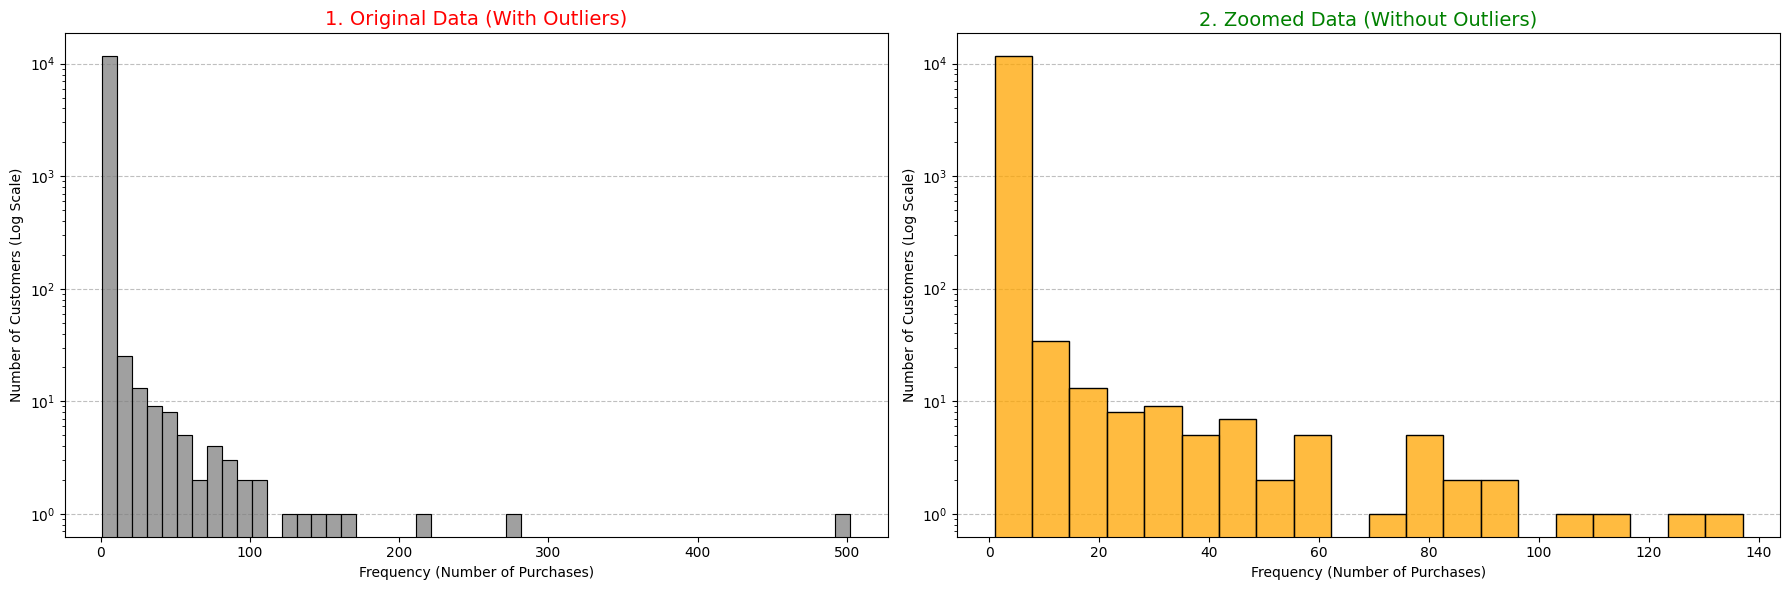

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- PLOT 1: ORIGINAL DATA (WITH OUTLIERS) ---
sns.histplot(rfm_f_df['Frequency'], kde=False, bins=50, color='gray', ax=axes[0])
axes[0].set_yscale('log') 
axes[0].set_title('1. Original Data (With Outliers)', fontsize=14, color='red')
axes[0].set_xlabel('Frequency (Number of Purchases)')
axes[0].set_ylabel('Number of Customers (Log Scale)')
axes[0].grid(True, axis='y', linestyle='--', alpha=0.8)
axes[0].set_axisbelow(True)

# --- PLOT 2: ZOOMED DATA (99.95th PERCENTILE) ---
limit_x = rfm_f_df['Frequency'].quantile(0.9995)
data_zoom = rfm_f_df[rfm_f_df['Frequency'] <= limit_x]['Frequency']

sns.histplot(data_zoom, kde=False, bins=20, color='orange', ax=axes[1])
axes[1].set_yscale('log') # Keep Log scale for consistency
axes[1].set_title(f'2. Zoomed Data (Without Outliers)', fontsize=14, color='green')
axes[1].set_xlabel('Frequency (Number of Purchases)')
axes[1].set_ylabel('Number of Customers (Log Scale)')
axes[1].grid(True, axis='y', linestyle='--', alpha=0.8
)
axes[1].set_axisbelow(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

* M - Monetary: ghép bảng giao dịch với giá tiền gần nhất trong bảng item

In [10]:
price_df = item_properties_df[item_properties_df['property'] == '790'].copy()
price_df['ISO datetime'] = pd.to_datetime(price_df['ISO datetime'])
price_df.head()

,timestamp,itemid,property,value,ISO datetime,date
3,1431226800000,59481,790,n15360.000,2015-05-10 03:00:00,2015-05-10
14,1434250800000,169055,790,n21000.000,2015-06-14 03:00:00,2015-06-14
16,1435460400000,178601,790,n5400.000,2015-06-28 03:00:00,2015-06-28
42,1431831600000,125874,790,n39588.000,2015-05-17 03:00:00,2015-05-17
46,1433646000000,272201,790,n10320.000,2015-06-07 03:00:00,2015-06-07


In [11]:
# Xử lý cột 'value' (loại bỏ 'n' và chuyển sang float)
price_data_clean = price_df.copy()
price_data_clean['clean_value'] = price_data_clean['value'].apply(
    lambda x: x.replace('n', '', 1) if isinstance(x, str) and x.startswith('n') else np.nan
)
price_data_clean['price'] = pd.to_numeric(price_data_clean['clean_value'], errors='coerce')
print(price_data_clean.head(2))

# giữ lại 3 cột cần thiết
price_df = price_data_clean[['ISO datetime', 'itemid', 'price']].rename(columns={'ISO datetime': 'PriceISO'})
price_df

        timestamp  itemid property       value        ISO datetime  \
3   1431226800000   59481      790  n15360.000 2015-05-10 03:00:00   
14  1434250800000  169055      790  n21000.000 2015-06-14 03:00:00   

          date clean_value    price  
3   2015-05-10   15360.000  15360.0  
14  2015-06-14   21000.000  21000.0  


,PriceISO,itemid,price
3,2015-05-10 03:00:00,59481,15360.0
14,2015-06-14 03:00:00,169055,21000.0
16,2015-06-28 03:00:00,178601,5400.0
42,2015-05-17 03:00:00,125874,39588.0
46,2015-06-07 03:00:00,272201,10320.0
...,...,...,...
20275852,2015-06-07 03:00:00,436865,0.0
20275860,2015-07-19 03:00:00,241233,12048.0
20275867,2015-05-31 03:00:00,463381,0.0
20275876,2015-07-12 03:00:00,147935,42720.0


In [12]:
print(price_df[price_df["itemid"] == 438400])

Empty DataFrame
Columns: [PriceISO, itemid, price]
Index: []


In [13]:
# Time-Based Merge : Ghép giá theo thời gian gần nhất 
transactions_df = transactions_df.sort_values('ISO datetime')
price_df = price_df.sort_values('PriceISO')

# asof backward tìm giá trị gần nhất của item_id
merged_df = pd.merge_asof(
    transactions_df,
    price_df,
    left_on='ISO datetime',
    right_on='PriceISO',
    by='itemid',
    direction='nearest', # Đổi từ 'backward' thành 'nearest' do có transaction chỉ có thông tin price sau khi mua
    tolerance=pd.Timedelta('100000 days') # (Tuỳ chọn) Chỉ lấy giá trong vòng 30 ngày đổ lại để tránh sai lệch quá lớn
)
# merged_df['price'] = merged_df['price'].fillna(0) # Gán giá 0 nếu không tìm thấy
merged_df

,timestamp,visitorid,event,itemid,transactionid,ISO datetime,date,PriceISO,price
0,1430623641391,869008,transaction,40685,9765.0,2015-05-03 03:27:21.391,2015-05-03,2015-05-10 03:00:00,19800.0
1,1430624101772,345781,transaction,438400,1016.0,2015-05-03 03:35:01.772,2015-05-03,NaT,NaN
2,1430625707591,586756,transaction,440917,10942.0,2015-05-03 04:01:47.591,2015-05-03,2015-05-10 03:00:00,30600.0
3,1430626058961,435495,transaction,175893,6173.0,2015-05-03 04:07:38.961,2015-05-03,2015-05-10 03:00:00,9960.0
4,1430627474903,266417,transaction,445106,12546.0,2015-05-03 04:31:14.903,2015-05-03,2015-05-10 03:00:00,5040.0
...,...,...,...,...,...,...,...,...,...
22452,1442542096512,152963,transaction,72462,5772.0,2015-09-18 02:08:16.512,2015-09-18,2015-09-13 03:00:00,15840.0
22453,1442542096512,152963,transaction,12504,5772.0,2015-09-18 02:08:16.512,2015-09-18,2015-09-13 03:00:00,16080.0
22454,1442542096528,152963,transaction,380196,5772.0,2015-09-18 02:08:16.528,2015-09-18,2015-09-13 03:00:00,194880.0
22455,1442543898098,152963,transaction,362697,5670.0,2015-09-18 02:38:18.098,2015-09-18,2015-05-10 03:00:00,34800.0


##### Có những giao dịch không có giá tiền của vật phẩm/item_id không trong db, xử lý bằng cách lấy trung bình để không làm tiền khách đã bỏ ra bị nhỏ quá, làm mất khách tiềm năng


In [14]:
nan_item = merged_df[merged_df['price'].isna()]
nan_item
nat_item = merged_df[merged_df['PriceISO'].isna()]
nat_item

,timestamp,visitorid,event,itemid,transactionid,ISO datetime,date,PriceISO,price
1,1430624101772,345781,transaction,438400,1016.0,2015-05-03 03:35:01.772,2015-05-03,NaT,NaN
60,1430684695946,53842,transaction,336945,9606.0,2015-05-03 20:24:55.946,2015-05-03,NaT,NaN
73,1430692866732,163561,transaction,386635,6042.0,2015-05-03 22:41:06.732,2015-05-03,NaT,NaN
113,1430721167315,849941,transaction,104432,848.0,2015-05-04 06:32:47.315,2015-05-04,NaT,NaN
145,1430761687717,681196,transaction,122734,9964.0,2015-05-04 17:48:07.717,2015-05-04,NaT,NaN
...,...,...,...,...,...,...,...,...,...
22301,1442405560865,672066,transaction,243343,5942.0,2015-09-16 12:12:40.865,2015-09-16,NaT,NaN
22348,1442430063333,748697,transaction,110645,6281.0,2015-09-16 19:01:03.333,2015-09-16,NaT,NaN
22414,1442503061050,748562,transaction,344902,9155.0,2015-09-17 15:17:41.050,2015-09-17,NaT,NaN
22420,1442508532165,871243,transaction,386523,2750.0,2015-09-17 16:48:52.165,2015-09-17,NaT,NaN


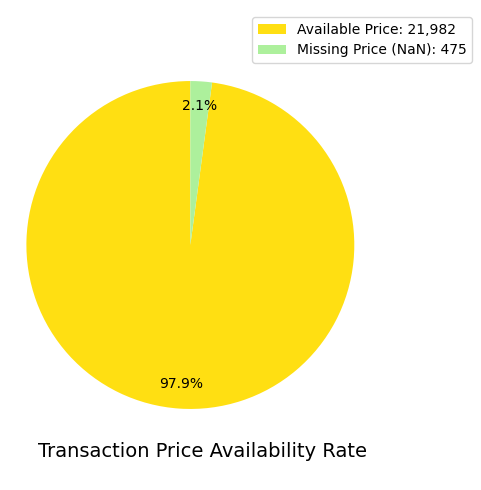

In [15]:
missing_price_count = merged_df['price'].isna().sum()
valid_price_count = len(merged_df) - missing_price_count

sizes = [valid_price_count, missing_price_count]

colors = ['#ffdf12', '#adf09c']

# real count
legend_labels = [f'Available Price: {valid_price_count:,}', f'Missing Price (NaN): {missing_price_count:,}']

plt.figure(figsize=(5, 5))
plt.pie(sizes, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
plt.legend(
    legend_labels,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)
)

# 6. Title ở dưới biểu đồ
plt.text(
    0.535, 0.05,
    'Transaction Price Availability Rate',
    ha='center',
    fontsize=14,
    transform=plt.gca().transAxes
)

plt.axis('equal')   # Giữ hình tròn chuẩn
plt.tight_layout()
plt.show()

In [16]:
# fill avg
avg_price_store = merged_df[merged_df['price'] > 0]['price'].mean()
merged_df['price'] = merged_df['price'].fillna(avg_price_store)
missing_count = merged_df['price'].isna().sum()
print(f"Number of itemid without price : {missing_count}")

Number of itemid without price : 0


* M:tổng tiền visitor_id has spent

In [17]:
# Tính tổng Monetary 
rfm_m_df = merged_df.groupby('visitorid')['price'].sum().reset_index(name='Monetary')
rfm_m_df

,visitorid,Monetary
0,172,99600.0
1,186,59880.0
2,264,94056.0
3,419,17160.0
4,539,34920.0
...,...,...
11714,1406787,54000.0
11715,1406981,143880.0
11716,1407070,79080.0
11717,1407110,20400.0


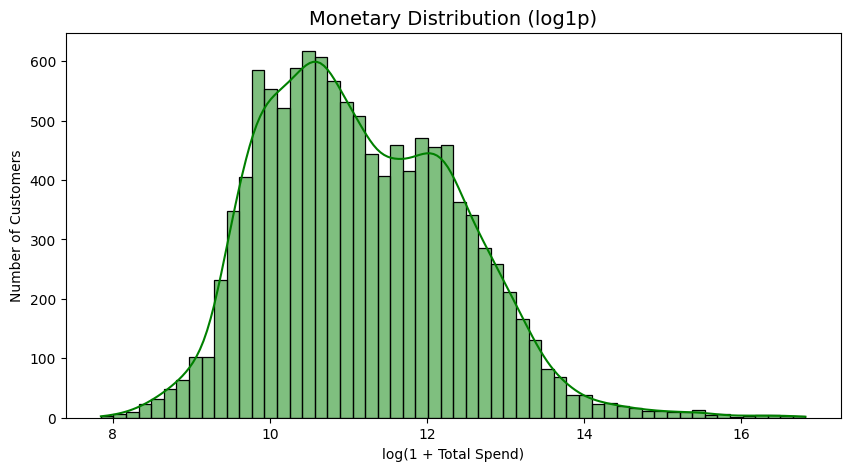

In [55]:
plt.figure(figsize=(10, 5))

rfm_m_df['Monetary_log'] = np.log1p(rfm_m_df['Monetary'])

limit_m = rfm_m_df['Monetary_log'].quantile(0.9995)

sns.histplot(
    rfm_m_df[rfm_m_df['Monetary_log'] <= limit_m]['Monetary_log'],
    kde=True,
    color='green'
)

plt.title('Monetary Distribution (log1p)', fontsize=14)
plt.xlabel('log(1 + Total Spend)')
plt.ylabel('Number of Customers')
plt.show()


In [19]:
## Combine R, F, M into a single DataFrame
rfm_df = rfm_r_df.merge(rfm_f_df, on='visitorid').merge(rfm_m_df, on='visitorid')
rfm_df

,visitorid,Recency,Frequency,Monetary,Monetary_log
0,172,35,1,99600.0,11.508927
1,186,37,1,59880.0,11.000115
2,264,11,1,94056.0,11.451656
3,419,51,1,17160.0,9.750395
4,539,94,1,34920.0,10.460844
...,...,...,...,...,...
11714,1406787,109,1,54000.0,10.896758
11715,1406981,123,1,143880.0,11.876742
11716,1407070,128,1,79080.0,11.278228
11717,1407110,45,1,20400.0,9.923339


In [20]:
rfm_df.to_csv('../dataset/rfm_scores_final.csv', index=False)
print(f"Tổng số khách hàng phân khúc: {len(rfm_df)}")
# print(rfm_df.head())

Tổng số khách hàng phân khúc: 11719


In [21]:
txn_items = set(transactions_df['itemid'])
prop_items = set(item_properties_df['itemid'])

missing_items = txn_items - prop_items
print(len(missing_items))
print(list(missing_items)[:10])   # xem 10 item đầu bị thiếu


380
[178176, 352258, 229382, 450587, 264221, 67614, 210975, 333869, 167985, 110645]


## 2. CLV:Customer Lifetime Value - Lợi nhuận dự kiến khách hàng mang lại trong suốt dòng đời của họ 
CLV trả lời câu hỏi: “Khách hàng này đáng giá bao nhiêu tiền trong tương lai?”


### Thư viện lifetimes khác cách tính bảng rfm
* f:số lần mua lặp lại (freq-1)
* r: khoảng cách từ lần mua đầu đến lần cuối != kcach lần cuối đến hiện tại
* t: khoảng cách từ lần mua đầu đến hiện tại

In [22]:
clean_transaction_log = merged_df[['visitorid', 'ISO datetime', 'price']].copy()
clean_transaction_log.rename(columns={
    'ISO datetime': 'date', 
    'price': 'monetary_value'
}, inplace=True)
clv_data = summary_data_from_transaction_data(
    clean_transaction_log,
    'visitorid',
    'date',
    monetary_value_col='monetary_value',
    observation_period_end='2015-09-18' # Ngày cuối cùng trong dataset RetailRocket
)



- Lọc bỏ các khách hàng chỉ mua 1 lần (Frequency = 0) 
- Vì mô hình Gamma-Gamma chỉ hoạt động với khách có lặp lại hành vi mua
- Tuy nhiên, để tính BG/NBD (xác suất quay lại) thì vẫn giữ khách mua 1 lần

In [23]:
print(f"Dữ liệu summary có {len(clv_data)} khách hàng.")
clv_data.tail(15)

Dữ liệu summary có 11719 khách hàng.


,frequency,recency,T,monetary_value
visitorid,,,,
1404894,0.0,0.0,10.0,0.0
1404991,0.0,0.0,88.0,0.0
1405688,0.0,0.0,93.0,0.0
1405714,0.0,0.0,125.0,0.0
1405831,0.0,0.0,77.0,0.0
1405861,0.0,0.0,121.0,0.0
1405929,0.0,0.0,15.0,0.0
1406087,0.0,0.0,108.0,0.0
1406564,0.0,0.0,23.0,0.0


In [24]:
# Lọc những khách đã mua > 1 lần để tính khoảng cách giữa các lần mua
repeat_customers = clv_data[clv_data['frequency'] > 0]

# Ước lượng thời gian trung bình giữa các lần mua (đơn vị: ngày)
avg_days_between_purchases = (repeat_customers['recency'] / repeat_customers['frequency']).mean()
median_days_between_purchases = (repeat_customers['recency'] / repeat_customers['frequency']).median()

print(f"Trung bình số ngày giữa 2 lần mua: {avg_days_between_purchases:.1f} ngày")
print(f"Trung vị số ngày giữa 2 lần mua: {median_days_between_purchases:.1f} ngày")

Trung bình số ngày giữa 2 lần mua: 14.1 ngày
Trung vị số ngày giữa 2 lần mua: 5.7 ngày


### BG/NBD: Beta Geometric / Negative Binomial Distribution
Mô hình thống kê dùng để dự đoán hành vi mua lặp lại của khách hàng trong tương lai

In [25]:
print("--- BẮT ĐẦU TỐI ƯU HÓA PENALIZER_COEF ---")

# 1. Chia dữ liệu: cắt 30 ngày cuối làm hold out
# Dữ liệu của bạn kết thúc vào 2015-09-18
observation_end = '2015-09-18'
calibration_end = '2015-08-18' # Lùi lại 1 tháng để làm tập train

summary_cal_holdout = calibration_and_holdout_data(
    clean_transaction_log, 
    'visitorid', 
    'date', 
    calibration_period_end=calibration_end,
    observation_period_end=observation_end
)

l2_params = [0.0005,0.001, 0.01, 0.05, 0.1, 0.2]
results = []

print(f"Đang test trên {len(summary_cal_holdout)} khách hàng...")

for coef in l2_params:
    # Train model
    bgf_test = BetaGeoFitter(penalizer_coef=coef)
    bgf_test.fit(summary_cal_holdout['frequency_cal'], 
                 summary_cal_holdout['recency_cal'], 
                 summary_cal_holdout['T_cal'])
    
    # duration_holdout 
    predicted_bgf = bgf_test.predict(
        summary_cal_holdout['duration_holdout'], 
        summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal']
    )
    
    actual = summary_cal_holdout['frequency_holdout']
    rmse = np.sqrt(mean_squared_error(actual, predicted_bgf))
    
    results.append({'penalizer_coef': coef, 'RMSE': rmse})
    print(f"Coef: {coef} | RMSE: {rmse:.5f} (Thấp hơn là tốt hơn)")

best_result = sorted(results, key=lambda x: x['RMSE'])[0]
print("\n--- KẾT QUẢ ---")
print(f"Penalizer tốt nhất nên dùng: {best_result['penalizer_coef']}")

--- BẮT ĐẦU TỐI ƯU HÓA PENALIZER_COEF ---
Đang test trên 9329 khách hàng...
Coef: 0.0005 | RMSE: 0.33941 (Thấp hơn là tốt hơn)
Coef: 0.001 | RMSE: 0.33945 (Thấp hơn là tốt hơn)
Coef: 0.01 | RMSE: 0.34485 (Thấp hơn là tốt hơn)
Coef: 0.05 | RMSE: 0.35943 (Thấp hơn là tốt hơn)
Coef: 0.1 | RMSE: 0.36868 (Thấp hơn là tốt hơn)
Coef: 0.2 | RMSE: 0.37892 (Thấp hơn là tốt hơn)

--- KẾT QUẢ ---
Penalizer tốt nhất nên dùng: 0.0005


In [26]:
# --- TRAIN BG/NBD (Dự đoán tần suất mua) ---
# Mô hình này cần TOÀN BỘ dữ liệu (cả người mua 1 lần) để học xác suất rời bỏ
bgf = BetaGeoFitter(penalizer_coef=0.0005)
bgf.fit(clv_data['frequency'], clv_data['recency'], clv_data['T'])


<lifetimes.BetaGeoFitter: fitted with 11719 subjects, a: 0.59, alpha: 1.10, b: 0.37, r: 0.01>

In [27]:
# Dự báo số lần mua trong 30 ngày tới
clv_data['predicted_purchases_30_days'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    30, clv_data['frequency'], clv_data['recency'], clv_data['T']
)

clv_data.head()

,frequency,recency,T,monetary_value,predicted_purchases_30_days
visitorid,,,,,
172,0.0,0.0,34.0,0.0,0.008512
186,0.0,0.0,37.0,0.0,0.007945
264,0.0,0.0,11.0,0.0,0.019520
419,0.0,0.0,51.0,0.0,0.006069
539,0.0,0.0,94.0,0.0,0.003533


In [28]:
clv_data['probability_alive'] = bgf.conditional_probability_alive(
                                    clv_data['frequency'],
                                    clv_data['recency'],
                                    clv_data['T'])
clv_data[clv_data['probability_alive']!=0]

,frequency,recency,T,monetary_value,predicted_purchases_30_days,probability_alive
visitorid,,,,,,
172,0.0,0.0,34.0,0.0,0.008512,1.0
186,0.0,0.0,37.0,0.0,0.007945,1.0
264,0.0,0.0,11.0,0.0,0.019520,1.0
419,0.0,0.0,51.0,0.0,0.006069,1.0
539,0.0,0.0,94.0,0.0,0.003533,1.0
...,...,...,...,...,...,...
1406787,0.0,0.0,109.0,0.0,0.003085,1.0
1406981,0.0,0.0,123.0,0.0,0.002759,1.0
1407070,0.0,0.0,128.0,0.0,0.002658,1.0


In [29]:
print(clv_data['probability_alive'].describe())
clv_data[clv_data['probability_alive']!=1]

count    1.171900e+04
mean     9.606421e-01
std      1.829647e-01
min      5.858708e-12
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: probability_alive, dtype: float64


,frequency,recency,T,monetary_value,predicted_purchases_30_days,probability_alive
visitorid,,,,,,
3926,1.0,15.0,108.0,3.240000e+04,0.021498,0.083289
4537,1.0,1.0,12.0,7.798800e+04,0.138859,0.090015
6699,1.0,1.0,134.0,8.052000e+04,0.001952,0.009238
8043,1.0,3.0,32.0,2.988000e+04,0.052669,0.070755
8411,1.0,17.0,24.0,3.480000e+04,0.291115,0.311583
...,...,...,...,...,...,...
1385029,4.0,6.0,90.0,1.460400e+05,0.000249,0.000205
1385073,7.0,14.0,51.0,1.116969e+06,0.006418,0.001832
1387237,1.0,1.0,135.0,1.799880e+05,0.001924,0.009170


In [30]:
print(bgf.summary)

           coef  se(coef)  lower 95% bound  upper 95% bound
r      0.012226  0.000641         0.010970         0.013481
alpha  1.103566  0.134819         0.839319         1.367812
a      0.588106  0.071638         0.447696         0.728515
b      0.370582  0.060495         0.252012         0.489151


In [31]:
# --- TRAIN GAMMA-GAMMA (Dự đoán giá trị đơn hàng) ---
# QUAN TRỌNG: Chỉ train trên 551 khách hàng đã mua lặp lại
returning_customers = clv_data[clv_data['frequency'] > 0]
returning_customers

,frequency,recency,T,monetary_value,predicted_purchases_30_days,probability_alive
visitorid,,,,,,
3926,1.0,15.0,108.0,3.240000e+04,0.021498,0.083289
4537,1.0,1.0,12.0,7.798800e+04,0.138859,0.090015
6699,1.0,1.0,134.0,8.052000e+04,0.001952,0.009238
8043,1.0,3.0,32.0,2.988000e+04,0.052669,0.070755
8411,1.0,17.0,24.0,3.480000e+04,0.291115,0.311583
...,...,...,...,...,...,...
1385029,4.0,6.0,90.0,1.460400e+05,0.000249,0.000205
1385073,7.0,14.0,51.0,1.116969e+06,0.006418,0.001832
1387237,1.0,1.0,135.0,1.799880e+05,0.001924,0.009170


* Kiểm tra giả định độc lập (Correlation nên gần 0)

In [32]:
corr_matrix = returning_customers[['frequency', 'monetary_value']].corr()
print(f"Hệ số tương quan F-M: {corr_matrix.iloc[0,1]:.4f} ") #(Càng thấp càng tốt)

Hệ số tương quan F-M: 0.2090 


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("--- TỐI ƯU HÓA PENALIZER CHO GAMMA-GAMMA ---")

# Lấy những khách hàng có lặp lại mua hàng (Frequency > 0)
# Gamma-Gamma chỉ quan tâm đến những người này
returning_customers_summary = clv_data[clv_data['frequency'] > 0]

# train test split
train_idx = returning_customers_summary.sample(frac=0.7, random_state=42).index
test_idx = returning_customers_summary.index.difference(train_idx)

train_data = returning_customers_summary.loc[train_idx]
test_data = returning_customers_summary.loc[test_idx]

gg_params = [0.0,0.0005, 0.001, 0.01, 0.05, 0.1, 0.5]

for coef in gg_params:
    # Train
    ggf_test = GammaGammaFitter(penalizer_coef=coef)
    ggf_test.fit(train_data['frequency'], train_data['monetary_value'])
    
    # Predict giá trị trung bình trên tập test
    predicted_monetary = ggf_test.conditional_expected_average_profit(
        test_data['frequency'],
        test_data['monetary_value']
    )
    
    # So sánh với giá trị thực tế (monetary_value hiện tại)
    actual_monetary = test_data['monetary_value']
    
    # Tính sai số (MAE thường dễ hình dung hơn với tiền tệ)
    mae = mean_absolute_error(actual_monetary, predicted_monetary)
    
    print(f"Coef: {coef} | Sai số trung bình (MAE): {mae:.2f}")

--- TỐI ƯU HÓA PENALIZER CHO GAMMA-GAMMA ---
Coef: 0.0 | Sai số trung bình (MAE): 88444.89
Coef: 0.0005 | Sai số trung bình (MAE): 11684.41
Coef: 0.001 | Sai số trung bình (MAE): 18245.41
Coef: 0.01 | Sai số trung bình (MAE): 90741.19
Coef: 0.05 | Sai số trung bình (MAE): 711684.24
Coef: 0.1 | Sai số trung bình (MAE): 1016131.66
Coef: 0.5 | Sai số trung bình (MAE): 559380.94


In [34]:
ggf = GammaGammaFitter(penalizer_coef=0.0005)
ggf.fit(returning_customers['frequency'], returning_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 551 subjects, p: 12.60, q: 0.16, v: 12.43>

In [35]:
# --- TÍNH CLV CHO TOÀN BỘ KHÁCH HÀNG ---
# (Dựa trên giả định họ sẽ hành xử giống những người tương tự nếu họ quay lại)
clv_data['CLV_1_months'] = ggf.customer_lifetime_value(
    bgf,
    clv_data['frequency'],
    clv_data['recency'],
    clv_data['T'],
    clv_data['monetary_value'],
    time=1, # 1 tháng
    freq='D',
    discount_rate=0.01
)

In [36]:
temp_df = clv_data.reset_index()

cols_to_select = ['visitorid', 'frequency', 'recency', 'T', 'CLV_1_months', 'probability_alive']
clv_results = temp_df[cols_to_select]
final_df = rfm_df.merge(clv_results.reset_index()[cols_to_select], on='visitorid', how='left')
final_df.fillna(0, inplace=True)

# Merge với bảng thông tin gốc
final_df = rfm_df.merge(clv_results, on='visitorid', how='left')

# Điền 0 cho những giá trị bị lỗi (nếu có)
final_df.fillna(0, inplace=True)

print("--- TOP 5 KHÁCH HÀNG CÓ GIÁ TRỊ TƯƠNG LAI CAO NHẤT ---")
# Hiển thị thêm cột probability_alive để dễ đánh giá
print(final_df.sort_values('CLV_1_months', ascending=False)[
    ['visitorid', 'CLV_1_months', 'probability_alive']
].head())

--- TOP 5 KHÁCH HÀNG CÓ GIÁ TRỊ TƯƠNG LAI CAO NHẤT ---
      visitorid  CLV_1_months  probability_alive
1250     152963  2.412217e+07           0.979692
9541    1150086  1.949441e+07           0.982453
1607     198270  1.403939e+07           0.718517
2037     247235  9.350531e+06           0.799907
4323     530559  7.557004e+06           0.753405


In [37]:
# Lọc ra danh sách những khách hàng có nguy cơ rời bỏ để gửi cho Marketing
churn_risk_customers = final_df[final_df['probability_alive'] < 0.9].sort_values('probability_alive')

print("--- DANH SÁCH KHÁCH HÀNG CẦN CHĂM SÓC ĐẶC BIỆT ---")
print(churn_risk_customers[['visitorid', 'frequency', 'recency', 'T', 'probability_alive']].head(10))

--- DANH SÁCH KHÁCH HÀNG CẦN CHĂM SÓC ĐẶC BIỆT ---
      visitorid  frequency  recency      T  probability_alive
1131     138131       36.0     59.0  137.0       5.858708e-12
1341     163561       18.0     32.0  138.0       1.739377e-10
5618     684514       16.0     19.0   93.0       4.827382e-10
6875     836635       14.0     16.0   92.0       1.110153e-09
9630    1161163       20.0     44.0  136.0       7.161873e-09
1863     227091       12.0     22.0  135.0       1.082992e-08
2348     286616       14.0     28.0  132.0       1.274131e-08
623       76757       21.0     49.0  135.0       2.631623e-08
424       53842       10.0     18.0  138.0       3.711346e-08
3187     389532        9.0     16.0  136.0       1.015289e-07


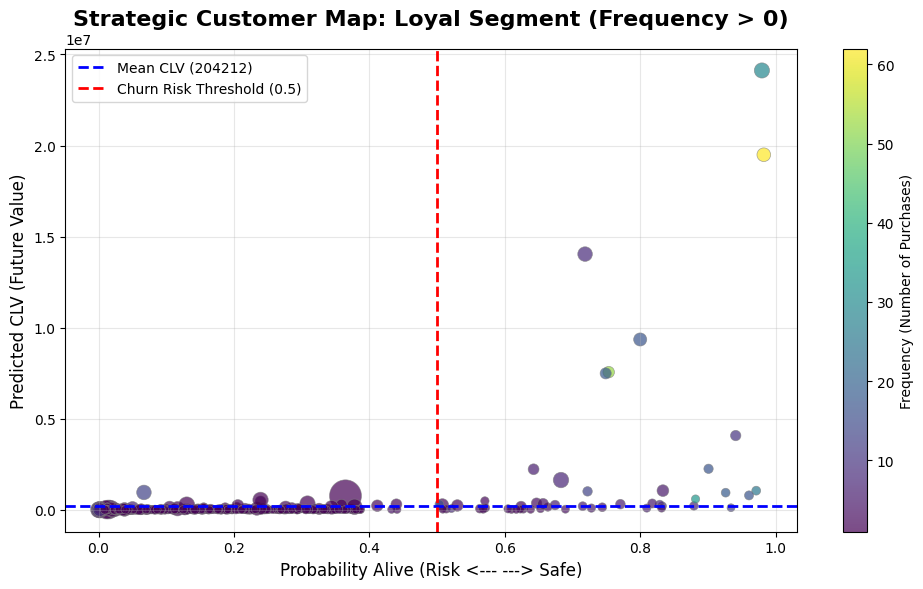

In [50]:
gc.collect()
plt.close('all')

# Lọc khách hàng thân thiết (mua > 1 lần)
mask = clv_data['frequency'] > 0
plot_data = clv_data[mask].copy()

x = plot_data['probability_alive']
y = plot_data['CLV_1_months']
colors = plot_data['frequency'] 
sizes = (plot_data['monetary_value'] / (plot_data['monetary_value'].max() + 1)) * 500 + 30

plt.figure(figsize=(10, 6))
sc = plt.scatter(x, y, c=colors, s=sizes, cmap='viridis', alpha=0.7, edgecolors='gray', linewidth=0.5)


avg_clv = plot_data['CLV_1_months'].mean()
plt.axhline(y=avg_clv, color='blue', linestyle='--', linewidth=2, label=f'Mean CLV ({avg_clv:.0f})')

plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Churn Risk Threshold (0.5)')


plt.title('Strategic Customer Map: Loyal Segment (Frequency > 0)', fontsize=16, fontweight='bold', color='black')
plt.xlabel('Probability Alive (Risk <--- ---> Safe)', fontsize=12)
plt.ylabel('Predicted CLV (Future Value)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
cbar = plt.colorbar(sc)
cbar.set_label('Frequency (Number of Purchases)')

plt.tight_layout()
plt.show()

A. Góc Trên - Trái (High CLV, Low Prob) $\rightarrow$ NHÓM CẦN CỨU GẤP (At Risk)Đặc điểm: Những chấm ở trên cao nhưng bị lệch về bên trái vạch đỏ (Prob < 0.5).
Ý nghĩa: Đây là khách "đại gia" (dự báo chi nhiều tiền) nhưng đang có dấu hiệu bỏ đi (xác suất sống thấp).Hành động: Đây là nhóm Ưu tiên số 1. Cần gửi email cá nhân hóa, tặng voucher giảm giá sâu hoặc gọi điện chăm sóc ngay lập tức để kéo họ quay lại. Mất họ là mất doanh thu lớn.

B. Góc Trên - Phải (High CLV, High Prob) $\rightarrow$ KHÁCH HÀNG KIM CƯƠNG (Champions)Đặc điểm: Những chấm ở trên cao và nằm bên phải vạch đỏ.Ý nghĩa: Khách VIP, mua nhiều tiền và vẫn đang mua đều đặn.Hành động: Chăm sóc để duy trì lòng trung thành. Đừng spam họ quá nhiều, hãy cho họ đặc quyền (thẻ VIP, quà sinh nhật, access sớm sản phẩm mới).

C. Góc Dưới - Phải (Low CLV, High Prob) $\rightarrow$ KHÁCH HÀNG TIỀM NĂNG (Promising)Đặc điểm: Những chấm nằm thấp nhưng sát bên phải (Prob gần 1.0).Ý nghĩa: Họ là khách hàng trung thành, mua rất đều nhưng giá trị đơn hàng còn thấp.Hành động: Cần Up-sell / Cross-sell. Gợi ý họ mua thêm combo, sản phẩm đắt tiền hơn để đẩy họ lên nhóm trên.

D. Góc Dưới - Trái (Low CLV, Low Prob) $\rightarrow$ KHÁCH HÀNG NGỦ ĐÔNG (Hibernating)Đặc điểm: Nằm thấp và bên trái.Ý nghĩa: Mua ít tiền và đã lâu không quay lại.Hành động: Có thể bỏ qua hoặc gửi email tự động giá rẻ. Không nên tốn nhiều chi phí Marketing vào nhóm này.